In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd

from src.transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Set this flag if this is for submission
is_submission = True

In [4]:
train = pd.read_csv("../data/processed/train.csv", sep=",")
test = pd.read_csv("../data/processed/test.csv", sep=",")

print("The shape of train is {}".format(train.shape))
print("The shape of test is {}".format(test.shape))

The shape of train is (16728, 54)
The shape of test is (5000, 53)


In [5]:
class PostProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = [
            "listing_id",
            "title",
            "model",
            "description",
            "original_reg_date",
            "reg_date",
            "category",
            "lifespan",
            "features",
            "accessories",
            "eco_category",
            "indicative_price",
            "reg_date_year",
            "reg_date_month",
            "coe_start_date",
            "coe_start_year",
            "coe_rebate",
            "dereg_value_computed",
            "manufactured",
            "mileage", "make_model", "engine_cap_range", "price", "coe_text", 
            "coe_expiry_days", "coe_expiry_date", "coe_start_date "
        ]
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        df = X.copy()
        df.loc[:,'last_reg_age'] = datetime.now().year - pd.to_datetime(df.reg_date).dt.year
        df.loc[:, 'mileage_log'] = np.log(df.mileage)
        df = df.drop(self.columns_to_drop, axis=1, errors="ignore")
        return df

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipe = Pipeline(
    [
        ("add_cat", SplitValuesToColumn("category")),
        ("post_processing", PostProcessing()),
        ('ohe', OheCategorical(['type_of_vehicle', 'transmission', 'brand_rank', 'opc_scheme', 'fuel_type', "make"]))
    ]
)

In [7]:
trainX = train
trainY = train.loc[:, 'price']

In [8]:
# list(X_train.columns)

In [9]:
if not is_submission:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=72)

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)

    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)

In [10]:
if is_submission:
    X_train = pipe.fit_transform(trainX)
    X_test = pipe.transform(test)
    y_train=trainY
else:
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)

print(f"X_Train:{X_train.shape}")

X_Train:(16728, 143)


In [26]:
list(X_test.columns)

['curb_weight',
 'power',
 'engine_cap',
 'no_of_owners',
 'depreciation',
 'coe',
 'road_tax',
 'dereg_value',
 'omv',
 'arf',
 'fuel_type_diesel',
 'fuel_type_petrol-electric',
 'fuel_type_petrol',
 'fuel_type_electric',
 'transmission_auto',
 'transmission_manual',
 'coe_expiry_months',
 'vehicle_age',
 'is_parf_car',
 'parf',
 'lifespan_restriction',
 'features_count',
 'accessories_count',
 'category_sta evaluated car',
 'category_coe car',
 'category_imported used vehicle',
 'category_direct owner sale',
 'category_consignment car',
 'category_low mileage car',
 'category_premium ad car',
 'category_rare & exotic',
 'category_sgcarmart warranty cars',
 'category_opc car',
 'category_electric cars',
 'category_hybrid cars',
 'category_vintage cars',
 'category_almost new car',
 'category_parf car',
 'last_reg_age',
 'mileage_log',
 ('bus/mini bus_type_of_vehicle',),
 ('hatchback_type_of_vehicle',),
 ('luxury sedan_type_of_vehicle',),
 ('mid-sized sedan_type_of_vehicle',),
 ('mpv_t

In [12]:
# Defining various algorithms

models = [
#     {"name": type(RandomForestRegressor()).__name__, "model": RandomForestRegressor, "params":{
#     "max_depth": [40, 50, 60, 100],
#     "max_features": ["sqrt"],
#     "n_estimators": [100, 200, 400]}
#     },
#     {"name": type(GradientBoostingRegressor()).__name__, "model": GradientBoostingRegressor, "params":{
#     "n_estimators": [1000, 2000],
#     "learning_rate": [0.05],
#     "max_depth": [5, 10],
#     "max_features": ["sqrt"]}
#     },
    {"name": type(GradientBoostingRegressor()).__name__, "model": GradientBoostingRegressor, "params":{
    "n_estimators": [2000],
    "learning_rate": [0.05],
    "max_depth": [5],
    "max_features": ["sqrt"]}
    },
#     {"name": type(Ridge()).__name__, "model": Ridge, "params":{
#     "solver": ["svd", "cholesky", "lsqr", "sag"],
#     "alpha": [0.00001, 0.0001, 0.01],
#     "fit_intercept": [True, False],
#     "normalize": [True, False]}
#     },
#     {"name": type(KNeighborsRegressor()).__name__, "model": KNeighborsRegressor, "params":{
#     "n_neighbors": [1, 3, 5]}
#     }
]

In [13]:
best_model = None
best_score = None
best_params = {}
for model in models:
    print(f"*** Training Model: {model['name']}")
    model_tuning = GridSearchCV(
        estimator=model['model'](),
        param_grid=model['params'],
        cv=3,
        verbose=3,
        n_jobs=-1,
    )

    model_tuning.fit(X_train, y_train)
    print(f"Best Params {model_tuning.best_params_}")
    print(f"Best Score {model_tuning.best_score_}")
    print("\n\n")
    
    if (best_score is None or best_score < model_tuning.best_score_):
        best_score = model_tuning.best_score_
        best_model = model['model']
        best_params = model_tuning.best_params_

print(f"Best Model: {best_model.__name__}")

*** Training Model: GradientBoostingRegressor
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Params {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 2000}
Best Score 0.964701443195088



Best Model: GradientBoostingRegressor


In [14]:
final_model = best_model(**best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)


In [17]:
test_price_path = "../data/test_price.csv"
p = pd.read_csv(test_price_path, header=None)
ids = p[p[1]!='None'][0].values

pred = y_pred[p[p[1]!='None'][0].values]
actual = p[p[1]!='None'][1].values
actual = actual.astype(float)

In [18]:
test['pred'] = y_pred
test.loc[ids, 'actual'] = actual

In [23]:
a = test[~test.actual.isna()]

a[abs(a.actual-a.pred) > 200000]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_parf_car,parf,coe_rebate,dereg_value_computed,lifespan_restriction,features_count,accessories_count,brand_rank,pred,actual
989,1016188,ferrari portofino 3.9a,ferrari,portofino,NaN,2018.0,NaN,2019-01-29 00:00:00,sports car,"parf car, direct owner sale, rare & exotic, lo...",...,1,321366.75,23613.333333,344980.083333,1,1,0,6,1.047048e+06,799999.0
1459,967174,bentley mulsanne s 6.75a,bentley,mulsanne,the bentley mulsanne is bentley's range-toppin...,2011.0,NaN,2011-11-30 00:00:00,luxury sedan,"parf car, rare & exotic",...,1,182193.00,1050.000000,183243.000000,1,6,7,6,4.985533e+05,269900.0
2793,914999,rolls royce phantom ewb (coe till 07/2030),rolls,royce,"sold. meyer motors bespoke, import any car wit...",2017.0,19-sep-2017,2020-07-30 00:00:00,luxury sedan,"imported used vehicle, coe car, rare & exotic",...,0,0.00,33125.000000,33125.000000,1,2,9,0,1.275874e+06,1700000.0
3352,1012432,rolls-royce phantom ewb,rolls-royce,phantom,"agent unit, original 2-toned paint colour, car...",2013.0,NaN,2014-01-08 00:00:00,luxury sedan,"parf car, rare & exotic, low mileage car",...,1,595842.50,20025.225000,615867.725000,1,1,0,6,9.069830e+05,1250000.0
3563,1030069,maybach 62 s long,maybach,62,bose premium stereo system. only 3 units in si...,2012.0,NaN,2012-12-21 00:00:00,luxury sedan,"parf car, premium ad car, low mileage car",...,1,370761.50,11316.666667,382078.166667,1,2,5,0,8.741241e+05,1390900.0
3973,943201,bentley flying spur 6.0a w12,bentley,flying,the new generation bentley flying spur w12 fir...,2019.0,NaN,2020-11-09 00:00:00,luxury sedan,"parf car, rare & exotic, almost new car, premi...",...,1,364696.50,35425.000000,400121.500000,1,2,6,6,1.127413e+06,1391000.0
4344,991928,rolls-royce silver shadow (coe till 03/2028),rolls-royce,silver,"produced between 1965 to 1980, car comes with ...",1973.0,15-jun-1973,2018-03-20 00:00:00,luxury sedan,"imported used vehicle, coe car, rare & exotic,...",...,0,0.00,2930.357913,2930.357913,1,2,5,6,4.390703e+05,135500.0


In [20]:
print(mean_squared_error(actual, pred, squared=False))

30007.098914223767


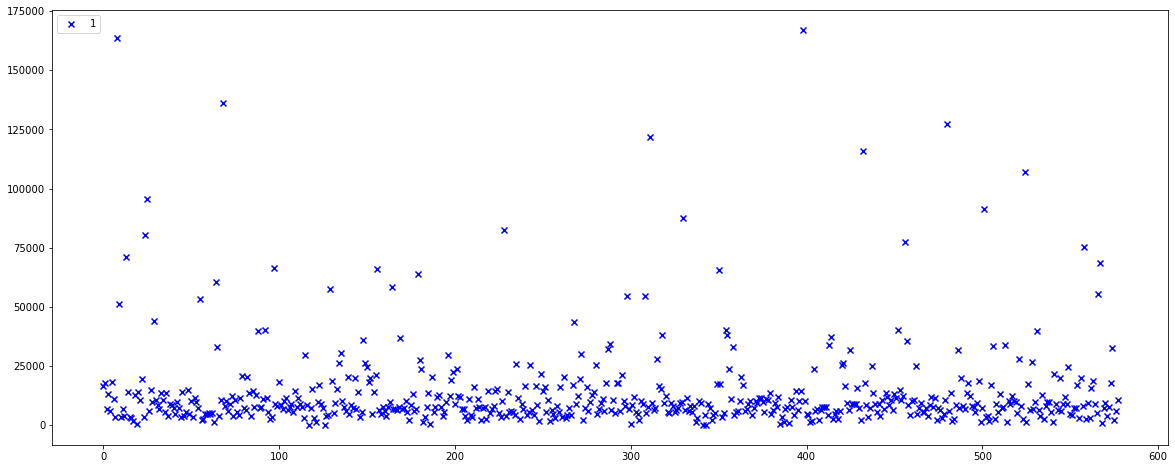

In [54]:

plt.figure(figsize=(20,8))
x=list(range(len(actual)))
plt.scatter(x,abs(actual-pred), c='b', marker='x', label='1')
# plt.scatter(x, pred, c='r', marker='s', label='-1')
plt.legend(loc='upper left')
plt.show()

In [14]:
if not is_submission:
    print(mean_squared_error(y_test, y_pred, squared=False))

In [28]:
if is_submission:
    my_submission = pd.DataFrame({'Id': list(test.index), 'Predicted': y_pred})
    my_submission.to_csv('submission.csv', index=False)

In [36]:
forest_importances[forest_importances <= 0.001].reset_index()

,index,0
0,fuel_type_diesel,6.391418e-04
1,fuel_type_petrol-electric,6.309997e-04
2,fuel_type_petrol,8.384404e-04
3,fuel_type_electric,2.570865e-05
4,transmission_manual,5.388434e-04
...,...,...
99,"(tesla_make,)",1.933287e-06
100,"(ud_make,)",1.401979e-07
101,"(volkswagen_make,)",4.289638e-05
102,"(volvo_make,)",1.230043e-05


<AxesSubplot:>

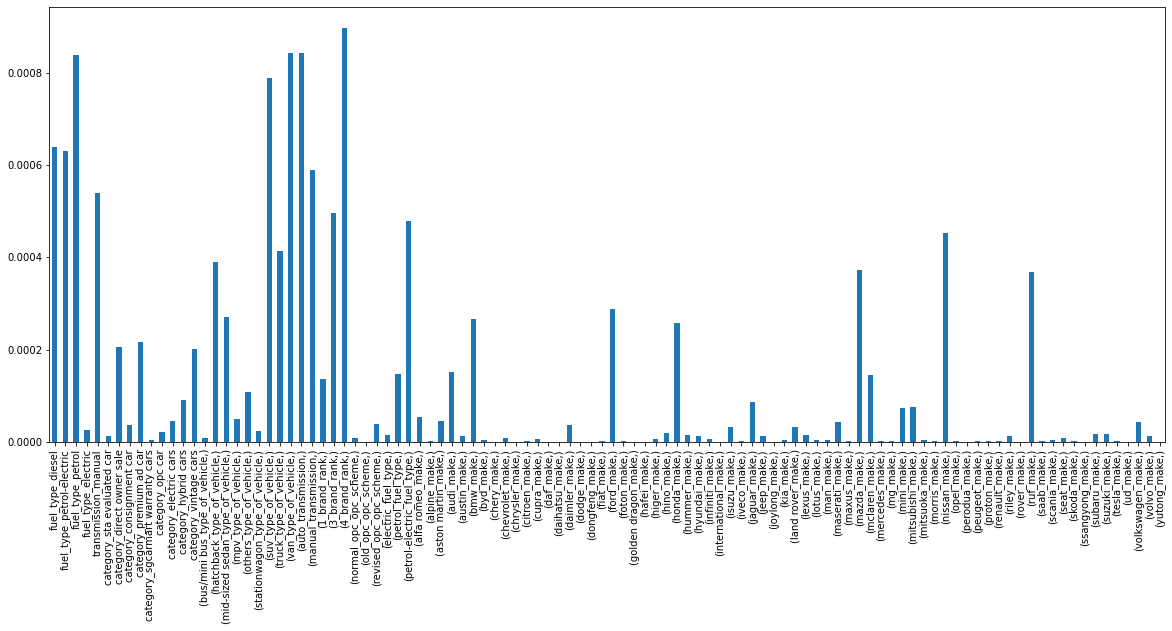

In [27]:
# plot feature importance

%matplotlib inline
import matplotlib.pyplot as plt

forest_importances = pd.Series(final_model.feature_importances_, index=list(X_train.columns))
forest_importances = forest_importances[forest_importances <= 0.001]

plt.figure(figsize=(20,8))
forest_importances.plot.bar()

In [17]:
# y_pred = best_model.predict(X_test)
# df = DataFrame(y_pred, columns=["Predicted"], )
# df.index.rename("Id", inplace=True)
# df.to_csv("dump.csv")

In [18]:
X_test.head(5)

,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,omv,arf,...,"(skoda_make,)","(ssangyong_make,)","(subaru_make,)","(suzuki_make,)","(tesla_make,)","(toyota_make,)","(ud_make,)","(volkswagen_make,)","(volvo_make,)","(yutong_make,)"
0,2070.0,225.0,2979.0,3.0,14870.0,39301.357272,2362.0,39301.357272,68994.0,68994.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1530.0,283.0,3800.0,5.0,31920.0,31553.000000,4366.0,23211.000000,115405.0,115405.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1955.0,190.0,2967.0,3.0,26640.0,53106.000000,3336.0,102072.000000,69922.0,97860.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1540.0,185.0,1998.0,1.0,19390.0,47501.000000,1210.0,73330.000000,49363.0,61109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1190.0,96.0,1496.0,2.0,9620.0,46489.000000,682.0,34555.000000,20184.0,10258.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
class Test(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.val_list = {}
        self.col = col

    def fit(self, df):
        categories = set()
        for values in df[self.col].unique():
            for value in values.split(","):
                if len(value.strip()) > 2:
                    categories.add(value.strip())

        self.val_list = categories
        return self

    def transform(self, input_df):
        col = self.col
        df = input_df.copy()
        df.reset_index(inplace=True, drop=True)
        df_cat = pd.DataFrame(
            df[col]
            .apply(
                lambda x: make_category_vector(
                    self.val_list, list(map(str.strip, x.split(",")))
                )
            )
            .tolist(), columns=self.val_list
        )
        df_cat = df_cat.add_prefix(col + "_")
        result = pd.concat([df, df_cat], axis=1)
        return result


In [85]:
df = train[['listing_id', 'make', 'category']]
a = Test('category').fit(df)
b=a.transform(df)

In [86]:
b[b.make=='rolls-royce']

,listing_id,make,category,category_low mileage car,category_electric cars,category_consignment car,category_premium ad car,category_rare & exotic,category_almost new car,category_vintage cars,category_opc car,category_parf car,category_sta evaluated car,category_imported used vehicle,category_sgcarmart warranty cars,category_hybrid cars,category_direct owner sale,category_coe car
265,1025654,rolls-royce,"parf car, rare & exotic, low mileage car",1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
548,1027235,rolls-royce,"imported used vehicle, coe car, rare & exotic",0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
601,1023783,rolls-royce,"parf car, rare & exotic, low mileage car",1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
630,1028638,rolls-royce,"coe car, rare & exotic, low mileage car",1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1015,1022386,rolls-royce,"coe car, rare & exotic, low mileage car",1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1153,994902,rolls-royce,"imported used vehicle, coe car, rare & exotic",0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1265,985507,rolls-royce,"coe car, rare & exotic, low mileage car",1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2312,1027105,rolls-royce,"parf car, direct owner sale, low mileage car",1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2654,953473,rolls-royce,"parf car, rare & exotic, premium ad car",0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
2929,954816,rolls-royce,"parf car, rare & exotic, premium ad car, low m...",1,0,0,1,1,0,0,0,1,0,0,0,0,0,0
